# Talking Points

Finding the drivers of point total from the 2014-2018 seasons

In [85]:
#acquire libraries
import pandas as pd

#explore libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import f_oneway

from prepare import wrangle_nba, scaled_wrangle_nba
from explore import elbow_plot, run_kmeans, add_to_train

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

#model libraries
from model import (select_kbest, rfe, linearReg_train, 
lassoLars_train, poly_linearReg_train, linearReg_validate,
lassoLars_validate, poly_linearReg_validate)

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

## Acquire

In [101]:
#uploading the nba csv and saving it as a dataframe called nba
nba = pd.read_csv('nba.games.stats.csv')

### Initial Analysis of the Data

In [6]:
#sneak peak into the data
nba.head()

,Unnamed: 0,Team,Game,Date,Home,Opponent,WINorLOSS,TeamPoints,OpponentPoints,FieldGoals,...,Opp.FreeThrows,Opp.FreeThrowsAttempted,Opp.FreeThrows.,Opp.OffRebounds,Opp.TotalRebounds,Opp.Assists,Opp.Steals,Opp.Blocks,Opp.Turnovers,Opp.TotalFouls
0,1,ATL,1,2014-10-29,Away,TOR,L,102,109,40,...,27,33,0.818,16,48,26,13,9,9,22
1,2,ATL,2,2014-11-01,Home,IND,W,102,92,35,...,18,21,0.857,11,44,25,5,5,18,26
2,3,ATL,3,2014-11-05,Away,SAS,L,92,94,38,...,27,38,0.711,11,50,25,7,9,19,15
3,4,ATL,4,2014-11-07,Away,CHO,L,119,122,43,...,20,27,0.741,11,51,31,6,7,19,30
4,5,ATL,5,2014-11-08,Home,NYK,W,103,96,33,...,8,11,0.727,13,44,26,2,6,15,29


In [91]:
nba.tail()

,Unnamed: 0,Team,Game,Date,Home,Opponent,WINorLOSS,TeamPoints,OpponentPoints,FieldGoals,...,Opp.FreeThrows,Opp.FreeThrowsAttempted,Opp.FreeThrows.,Opp.OffRebounds,Opp.TotalRebounds,Opp.Assists,Opp.Steals,Opp.Blocks,Opp.Turnovers,Opp.TotalFouls
9835,78119,WAS,78,2018-04-03,Away,HOU,L,104,120,38,...,18,27,0.667,10,46,26,13,3,9,14
9836,79119,WAS,79,2018-04-05,Away,CLE,L,115,119,47,...,22,28,0.786,5,35,26,10,3,16,14
9837,80119,WAS,80,2018-04-06,Home,ATL,L,97,103,35,...,16,23,0.696,7,50,24,5,5,18,22
9838,81124,WAS,81,2018-04-10,Home,BOS,W,113,101,41,...,22,27,0.815,13,44,22,14,1,16,18
9839,82119,WAS,82,2018-04-11,Away,ORL,L,92,101,33,...,22,27,0.815,6,42,20,6,7,16,27


In [7]:
#checking to see how many rows and columns there are
nba.shape

(9840, 41)

In [8]:
#checking data types, null values, and column names
nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9840 entries, 0 to 9839
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                9840 non-null   int64  
 1   Team                      9840 non-null   object 
 2   Game                      9840 non-null   int64  
 3   Date                      9840 non-null   object 
 4   Home                      9840 non-null   object 
 5   Opponent                  9840 non-null   object 
 6   WINorLOSS                 9840 non-null   object 
 7   TeamPoints                9840 non-null   int64  
 8   OpponentPoints            9840 non-null   int64  
 9   FieldGoals                9840 non-null   int64  
 10  FieldGoalsAttempted       9840 non-null   int64  
 11  FieldGoals.               9840 non-null   float64
 12  X3PointShots              9840 non-null   int64  
 13  X3PointShotsAttempted     9840 non-null   int64  
 14  X3PointS

In [9]:
#looking at the summary statistics of all the numeric columns
nba.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,9840.0,11960.157012,18654.867508,1.000,2537.750,5141.500,7715.250,82119.000
Game,9840.0,41.500000,23.670804,1.000,21.000,41.500,62.000,82.000
TeamPoints,9840.0,103.652337,12.188043,64.000,95.000,103.000,112.000,149.000
OpponentPoints,9840.0,103.652337,12.188043,64.000,95.000,103.000,112.000,149.000
FieldGoals,9840.0,38.602439,5.029992,19.000,35.000,38.000,42.000,58.000
FieldGoalsAttempted,9840.0,84.902439,7.130043,60.000,80.000,85.000,89.000,129.000
FieldGoals.,9840.0,0.455689,0.054711,0.271,0.418,0.455,0.494,0.684
X3PointShots,9840.0,9.126829,3.598084,0.000,7.000,9.000,11.000,25.000
X3PointShotsAttempted,9840.0,25.623679,7.102501,4.000,21.000,25.000,30.000,61.000
X3PointShots.,9840.0,0.354321,0.097782,0.000,0.290,0.353,0.419,0.750


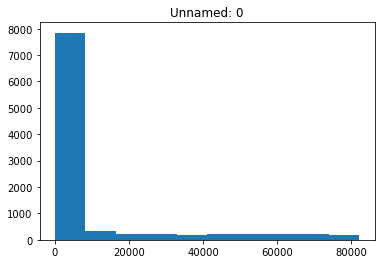

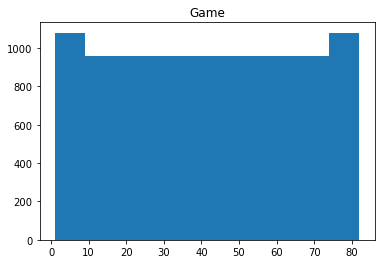

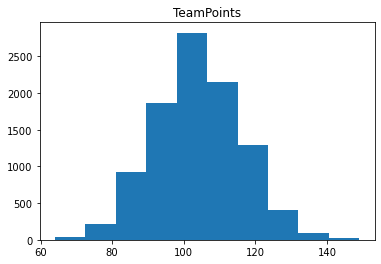

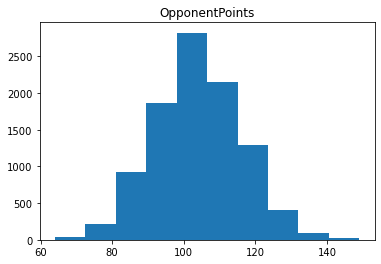

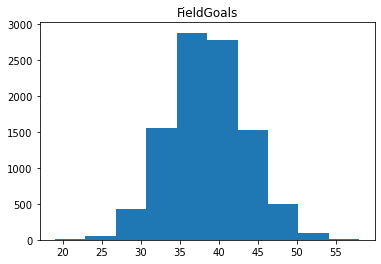

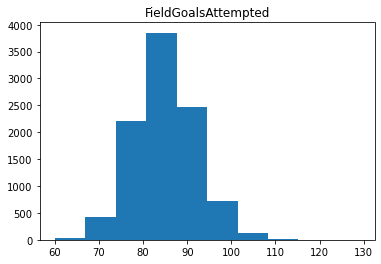

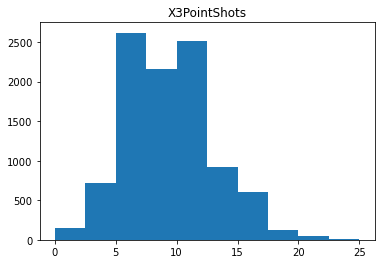

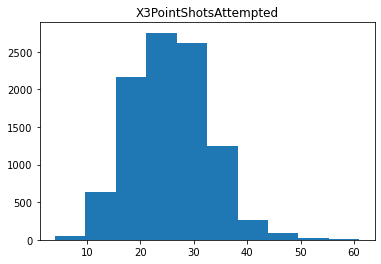

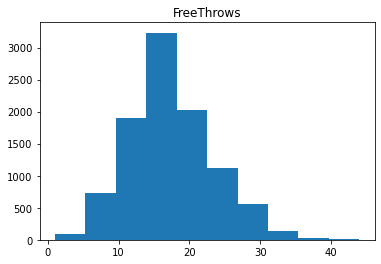

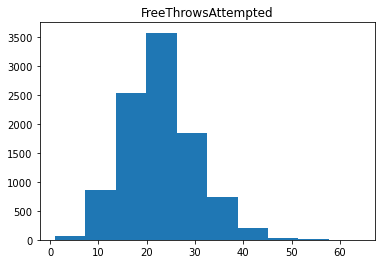

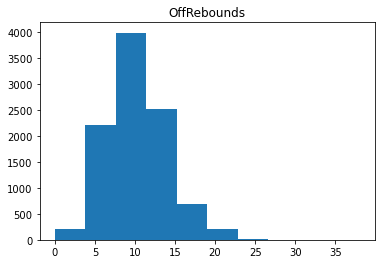

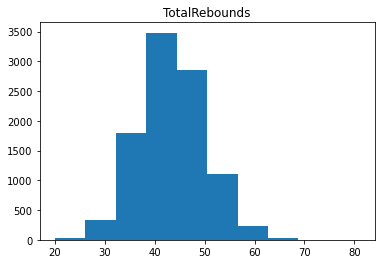

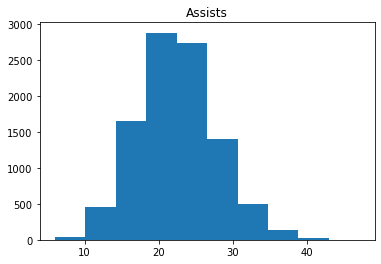

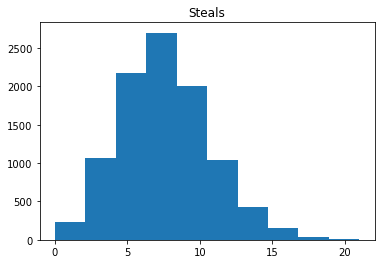

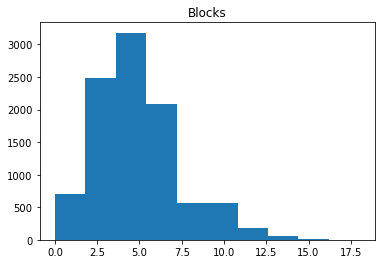

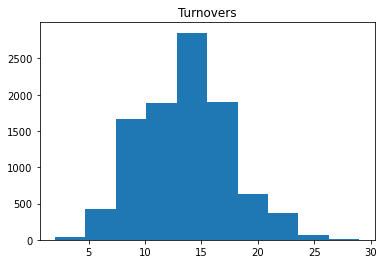

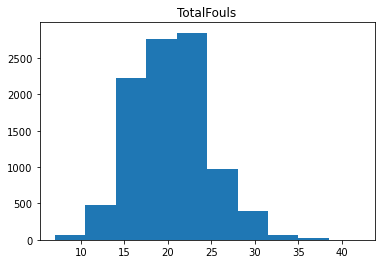

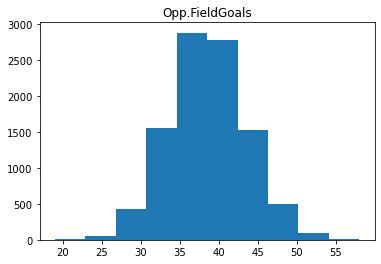

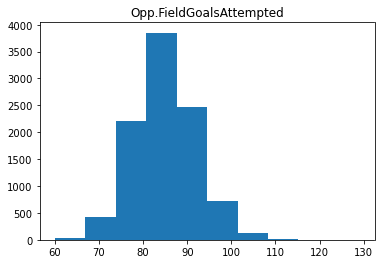

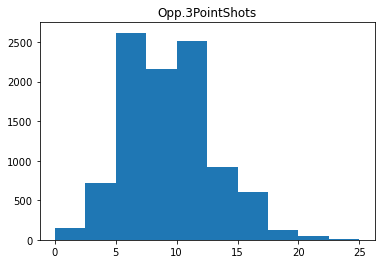

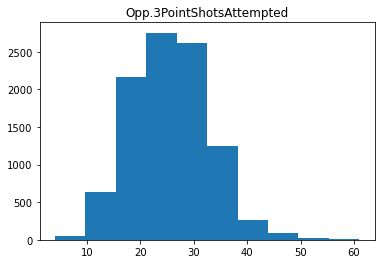

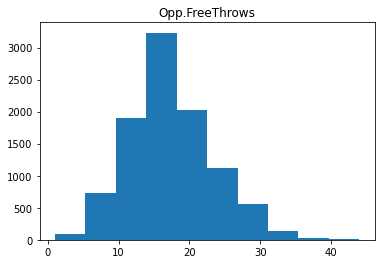

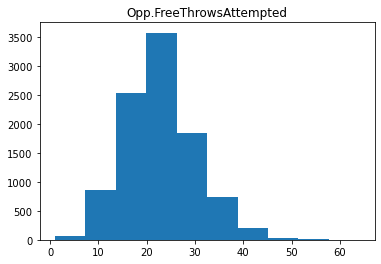

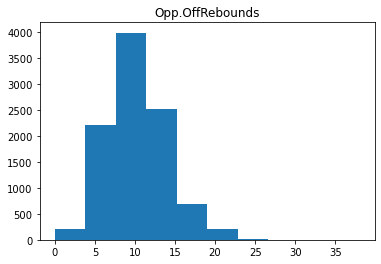

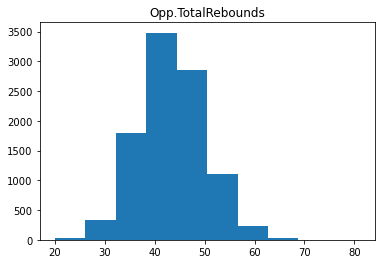

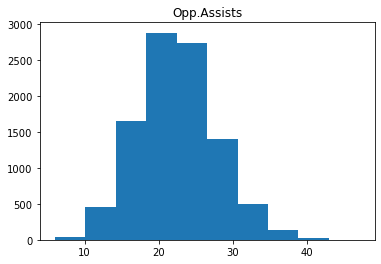

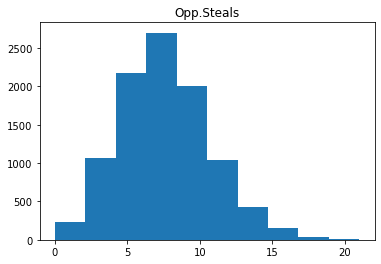

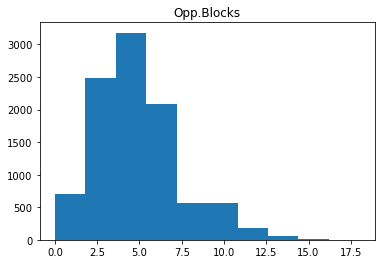

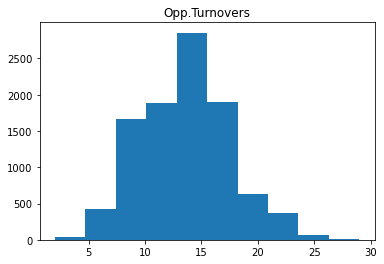

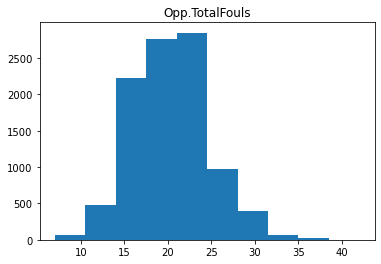

In [10]:
#checking plot distribution for all numerical columns
num_cols = nba.columns[[nba[col].dtype == 'int64' for col in nba.columns]]
for col in num_cols:
    plt.hist(nba[col])
    plt.title(col)
    plt.show()

<div class="alert alert-block alert-info"><b>Acquire Summary:</b>
    
* We will delete unnamed column because it wont be necessary
    
* We won't need game number because it will be in the index 
    
* Four seasons worth of data, we could look into splitting up the seasons 
    
* No null values, BIG PLUS! 
    
* Some outliers but its just a part of the game. Will keep all the data but could consider removing the outliers later 
    
* Normal distribution for all of the numerical columns
    
</div>

## Prepare

<div class="alert alert-block alert-info">
    
- adding two columns called home_is_west and away_is_west for teams playing in different conferences 
- Changed Home, Conference, Opp.Conference and Wins into dummy variables 
- dropped dates and columns that deal with point totals to not skew the models to predict who wins 
- split into train, validate and test
    
</div>

## Explore

In [11]:
train, validate, test = wrangle_nba()

In [12]:
train.head()

,Team,Opponent,TeamPoints,FieldGoals.,X3PointShots.,FreeThrows.,OffRebounds,TotalRebounds,Assists,Steals,...,Opp.OffRebounds,Opp.TotalRebounds,Opp.Assists,Opp.Steals,Opp.Blocks,Opp.Turnovers,Opp.TotalFouls,home_is_west,away_is_west,Home
7544,BRK,IND,131,0.479,0.400,0.906,11,43,22,7,...,14,47,29,12,9,14,25,0,0,0
3403,IND,PHO,97,0.410,0.200,0.735,10,46,14,16,...,13,53,15,4,2,22,23,0,1,0
8265,HOU,DAL,105,0.464,0.378,0.714,6,45,21,5,...,17,53,27,5,2,10,18,1,1,0
2225,TOR,MIL,124,0.523,0.600,0.792,15,57,27,8,...,8,30,19,11,1,12,18,0,0,1
5027,BOS,CHO,96,0.436,0.321,0.731,5,46,26,7,...,16,53,21,10,4,12,21,0,0,1


In [10]:
X_train = train.drop(columns = ['TeamPoints'])
y_train = train.TeamPoints

In [13]:
abs(train.corr().TeamPoints).sort_values(ascending = False)

TeamPoints           1.000000
FieldGoals.          0.715916
Assists              0.581885
X3PointShots.        0.479659
Opp.TotalRebounds    0.294783
Opp.TotalFouls       0.211711
FreeThrows.          0.178378
TotalFouls           0.149589
Opp.Blocks           0.141265
Turnovers            0.118230
Opp.Assists          0.118153
Home                 0.104941
Opp.FieldGoals.      0.102473
Opp.Steals           0.099355
Steals               0.093689
TotalRebounds        0.092601
home_is_west         0.079488
Blocks               0.060732
Opp.3PointShots.     0.034682
Opp.FreeThrows.      0.023883
Opp.Turnovers        0.023673
away_is_west         0.022586
Opp.OffRebounds      0.012581
OffRebounds          0.008963
Name: TeamPoints, dtype: float64

- 

### Are the Home team point totals dramatically different from the Away team points?
- $H_0$: The average points scored by Home and Away teams are not significantly different
- $H_a$: The average points scored by Home and Away teams are significantly different

In [14]:
alpha = 0.01

In [15]:
home = train[train.Home == 1]
away = train[train.Home == 0]

t, p = stats.ttest_ind(home.TeamPoints, away.TeamPoints)

In [16]:
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
p

We reject the null hypothesis


5.740461831462349e-15

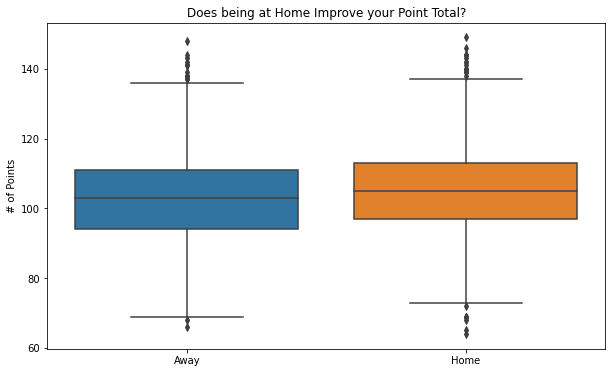

In [114]:
plt.figure(figsize=(10,6))
sns.boxplot(x="Home", y="TeamPoints", data=train)
plt.title('Does being at Home Improve your Point Total?')
plt.xticks([0, 1], ['Away', 'Home'])
plt.ylabel('# of Points')
plt.xlabel('')
plt.show()

In [18]:
print("The average points scored for the Home team is", round(train[train.Home == 1].TeamPoints.mean(),2))

The average points scored for the Home team is 105.26


In [19]:
print("The average points scored for the Away team is", round(train[train.Home == 0].TeamPoints.mean(),2))

The average points scored for the Away team is 102.69


**Takeaway**:
- The difference between 105 and 103 points is not a big numerical difference but the evidence suggest that it is a significant one.

### Do Home teams in the West score more points than Home teams in the East?
- $H_0$: The average points scored by West and East Home teams are not significantly different
- $H_a$: The average points scored by West and East Home teams are significantly different

In [22]:
home_west = train[train.home_is_west == 1]
home_east = train[train.home_is_west == 0]

t, p = stats.ttest_ind(home_west.TeamPoints, home_east.TeamPoints)

In [23]:
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
p

We reject the null hypothesis


3.454692117851272e-09

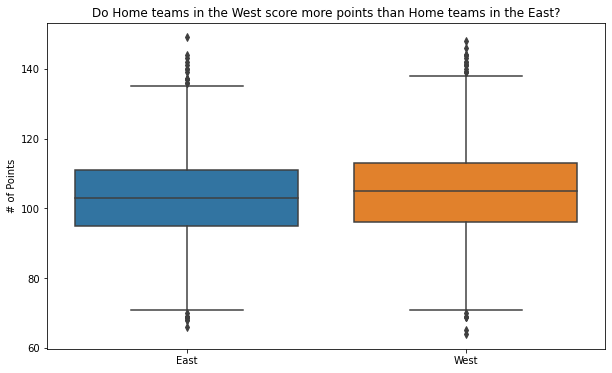

In [113]:
plt.figure(figsize=(10,6))
sns.boxplot(x="home_is_west", y="TeamPoints", data=train)
plt.title('Do Home teams in the West score more points than Home teams in the East?')
plt.xticks([0, 1], ['East', 'West'])
plt.ylabel('# of Points')
plt.xlabel('')
plt.show()

In [26]:
print("The average points scored for the Home team in the West is", round(train[train.home_is_west == 1].TeamPoints.mean(),2))

The average points scored for the Home team is 104.96


In [27]:
print("The average points scored for the Home team in the East is", round(train[train.home_is_west == 0].TeamPoints.mean(),2))

The average points scored for the Home team in the East is 103.01


**Takeaway**:
- The difference between 105 and 103 points is not a big numerical difference but the evidence suggest that it is a significant one.

### Do Away teams in the West score more points than Away teams in the East?
- $H_0$: The average points scored by West and East Away teams are not significantly different
- $H_a$: The average points scored by West and East Away teams are significantly different

In [29]:
away_west = train[train.away_is_west == 1]
away_east = train[train.away_is_west == 0]

t, p = stats.ttest_ind(away_west.TeamPoints, away_east.TeamPoints)

In [30]:
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
p

We fail to reject the null hypothesis


0.09366749466158963

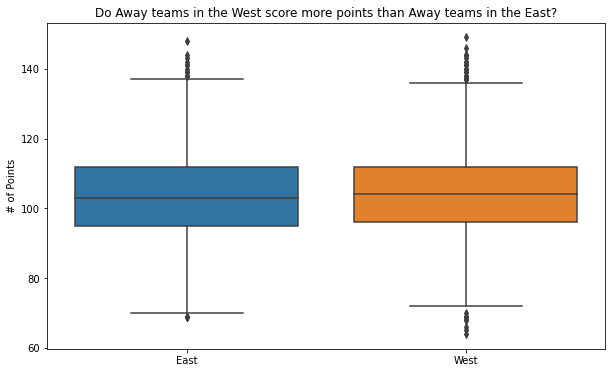

In [112]:
plt.figure(figsize=(10,6))
sns.boxplot(x="away_is_west", y="TeamPoints", data=train)
plt.title('Do Away teams in the West score more points than Away teams in the East?')
plt.xticks([0, 1], ['East', 'West'])
plt.ylabel('# of Points')
plt.xlabel('')
plt.show()

In [32]:
print("The average points scored for the Away team in the West is", round(train[train.away_is_west == 1].TeamPoints.mean(),2))

The average points scored for the Away team in the West is 104.26


In [33]:
print("The average points scored for the Away team in the East is", round(train[train.away_is_west == 0].TeamPoints.mean(),2))

The average points scored for the Away team in the East is 103.71


**Takeaway**:
- The data shows that the points scored by an Away East team and an Away West team is only half a point
- The difference is not significant enough to state one conference score more points than the other when they are away. 

### Is there a significant difference between points scored by a team and their opponents blocks?
- $H_0$: The average points scored by a team and the number of their opponents blocks are not significantly different
- $H_a$: The average points scored by a team and the number of their opponents blocks are significantly different

In [38]:
train['Opp.Blocks'].value_counts()

4     972
5     822
3     821
6     659
2     573
7     491
8     323
1     289
9     197
0     105
10    104
11     83
12     30
13     25
14      9
15      3
16      2
17      2
Name: Opp.Blocks, dtype: int64

In [83]:
no_blocks = train[train['Opp.Blocks'] == 0].TeamPoints
one_blocks = train[train['Opp.Blocks'] == 1].TeamPoints
two_blocks = train[train['Opp.Blocks'] == 2].TeamPoints
three_blocks = train[train['Opp.Blocks'] == 3].TeamPoints
four_blocks = train[train['Opp.Blocks'] == 4].TeamPoints
five_blocks = train[train['Opp.Blocks'] == 5].TeamPoints
six_blocks = train[train['Opp.Blocks'] == 6].TeamPoints
seven_blocks = train[train['Opp.Blocks'] == 7].TeamPoints
eight_blocks = train[train['Opp.Blocks'] == 8].TeamPoints
nine_blocks = train[train['Opp.Blocks'] == 9].TeamPoints
ten_blocks = train[train['Opp.Blocks'] == 10].TeamPoints
eleven_blocks = train[train['Opp.Blocks'] == 11].TeamPoints
twelve_blocks = train[train['Opp.Blocks'] == 12].TeamPoints
thirteen_blocks = train[train['Opp.Blocks'] == 13].TeamPoints
fourteen_blocks = train[train['Opp.Blocks'] == 14].TeamPoints
fifteen_blocks = train[train['Opp.Blocks'] == 15].TeamPoints
sixteen_blocks = train[train['Opp.Blocks'] == 16].TeamPoints
seventeen_blocks = train[train['Opp.Blocks'] == 17].TeamPoints

In [86]:
f, p = f_oneway(no_blocks, one_blocks, two_blocks, three_blocks, four_blocks, five_blocks, six_blocks, seven_blocks, eight_blocks, nine_blocks, ten_blocks, eleven_blocks, twelve_blocks, thirteen_blocks, fourteen_blocks, fifteen_blocks, sixteen_blocks, seventeen_blocks)

In [87]:
if p < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p

We reject the null


1.51080949193264e-18

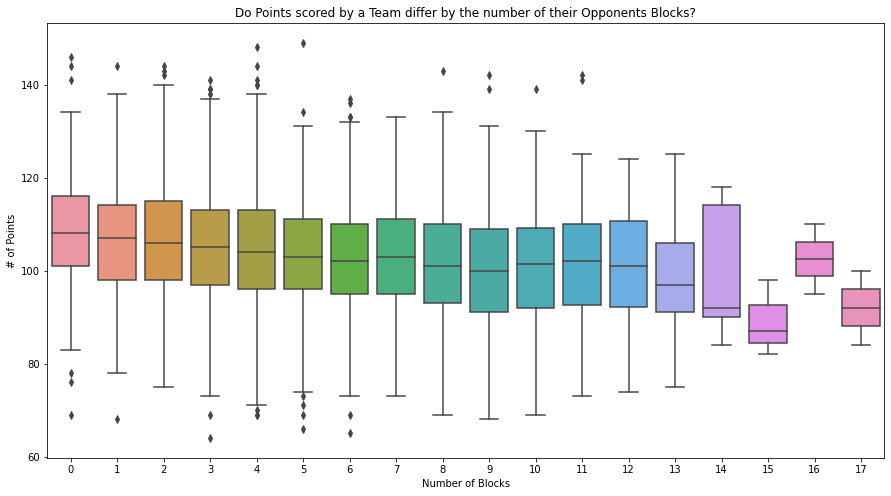

In [110]:
plt.figure(figsize=(15,8))
sns.boxplot(x="Opp.Blocks", y="TeamPoints", data=train)
plt.title('Do Points scored by a Team differ by the number of their Opponents Blocks?')
plt.ylabel('# of Points')
plt.xlabel('Number of Blocks')
plt.show()

**Takeaway**:
- The data shows that there difference is a significant difference to between points scored by a team and the number of their opponents blocks.
- It appears that as the number of blocks by their opponents increase, the amoun of points scored by a team decreases.
- There are a few outliers and exceptions but there is a very small sample size for opponents blocks for numbers greater than 10.